# Topic Modelling: An Empirical Approach to Theme Detection

Now that we have descriptively explored the 20 newsgroups dataset through corpus linguistics techniques, let's try to automatically detect their themes through an unsupervised machine learning model. Given the fact that we already know how the documents in this corpus are labelled (categorised), it is an excellent way to test the validity of the model - and see how powerful it can be. To use a car metaphor, the algorithm is now in the driver's seat, but we have full control over how it drives and where it is going.

**Topic modelling** is a very popular natural language processing (NLP) technique with applications across a vast variety of academic and industrial domains. JSTOR, for example, uses topic models to restrict search results to specific categories; lawyers and journalists use the technique to better understand immense volumes of legal documents and news stories without having to read all of their content.

In this session, we will not only implement the **Latent Dirichlet Allocation (LDA)** topic model, but also interactively visualise and interpret its results. This interactive visualisation will allow us to adjust the parameters of the model until we arrive at the right optimisation for our corpus.

Topic modelling bibliography: https://mimno.infosci.cornell.edu/topics.html
<br> LDA foundational paper (Blei, Ng, & Jordan 2003): http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
<br> LDA for English majors: http://www.matthewjockers.net/2011/09/29/the-lda-buffet-is-now-open-or-latent-dirichlet-allocation-for-english-majors/

## Download and import packages and modules

In [ ]:
# https://github.com/amueller/mglearn
!pip install mglearn

In [1]:
import pandas as pd
import numpy as np
import mglearn
import warnings; warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('seaborn')
import seaborn as sns
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)

## Load dataset

We'll use six newsgroup categories this time, which represent six topics. They should be quite distinct as they are chosen from different forum groups (no two are subcategories of the same group). Because we are interested in seeing how the algorithm will describe the documents thematically without being supervised, we will have only one corpus containing all posts from all six topics - remember that the algorithm does not know how many categories are represented. This is the inverse of the approach that we took for corpus linguistics with NLTK, in which we compared the vocabularies of different categories (each category constituted its own corpus).

The topic modelling corpus is one long list of strings, each of which represents a document. This is the input that we will feed into our text preprocessor.

20 newsgroups dataset homepage: http://qwone.com/~jason/20Newsgroups/

In [2]:
subcategories = ['comp.graphics', 'rec.autos', 'sci.space', 'misc.forsale', 'talk.politics.guns', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(categories=subcategories, remove=('headers', 'footers', 'quotes'))
docs_raw = newsgroups.data
print('Number of documents:', len(docs_raw))

Number of documents: 3501


In [3]:
print(docs_raw[1]) # Second document.

i have a question for you all related to this.  jesus condemns divorce
several times in the new testament, and i have a hard time with this.
the catholic church (as far as i can tell) does grant annulments with
the statement that the marriage never really existed in God's eyes.
(please, if i am mistinterpreting, correct me.)  however, i have
witnessed marriages where two people were very much in love but
recognized that they were destroying themselves and each other by
staying in a marriage, and that the problems were due to personal
childhood issues that had never been resolved.  i ask you, is divorce
justified in such a case?  they knew who they were, what they were
doing, they were deeply in love, but in the end, it did not work out.
i must admit that i don't see jesus forcing them to live together, or
even condemning that they go and seek happiness with someone else
later on.  opinions?

vera
*******************************************************************************
I am your 

## Text preprocessing and vectorization

Text preprocessing, which comprises tokenization and the removal of certain words and characters, is an extremely important stage of topic modelling. In machine learning terms, it represents a form of feature engineering - different features can dramatically change the results of the topic modelling algorithm.

The input for topic modelling algorithms is a matrix of numbers: strings are not accepted. Thus, we must go a step beyond just tokenizing text (as demonstrated by the corpus linguistics session) to *vectorizing* it. To be more precise, the matrix is a **document-term matrix** - rows are documents (in this case forum posts), and columns are terms (the vocabulary of the corpus). Individual cells contain numbers that represent the frequency of words. Topic modelling operates on a **bag of words (BoW)** approach, which means that word order is not important; only the number of times they occur is needed.

There are two types of frequencies: **term frequency (tf)** and **term frequency-inverse document frequency (tf-idf)**. 
- *Term frequency* is document-level - it is a simple count of the number of times each word appears in each document. This is the most straightforward counting technique, but the problem is that longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.
- *Term frequency-inverse document frequency* takes the entire corpus into account. The most frequent words in the corpus have the lowest idf scores; the least frequent words have the highest idf scores. tf-idf scores balance document frequency (which increases the score) against corpus frequency (which decreases the score). They downscale the weights of words that appear in many documents in the corpus, as these are less informative than those that only occur in a smaller portion of the corpus. They thus highlight words that are more interesting. 
     - Formula: `tf-idf(d, t) = tf(t) * idf(d, t)` 

Scikit-learn's `feature_extraction.text` module contains excellent tools for vectorization: `CountVectorizer` for term frequencies and `TfidfVectorizer` for term frequency-inverse document frequencies. These vectorizers allow for a great degree of vocabulary customisation. 
- We will remove accents, strip stopwords, lowercase all text, only consider alphabetical characters (not numbers), and remove tokens of less than three characters. 
- `max_df` specifies the maximum proportion of documents the word can be in; it thereby represents corpus-specific stopwords. We will only consider words that occur in no more than half of all documents.
- On the other hand, the `min_df` argument spcifies the minimum number of documents the word should be in to be included (i.e., the cut-off). We will only consider words that occur in at least ten documents (which by definition excludes hapax legomena).

`CountVectorizer` documentation: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
<br>`TfidfVectorizer` documentation: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [4]:
tf_vectorizer = CountVectorizer(strip_accents='unicode',
                                stop_words='english',
                                lowercase=True,
                                token_pattern=r'\b[A-Za-z]{3,}\b',
                                max_df=0.5, 
                                min_df=10)

Call the `fit()` function to tokenise the text and learn a vocabulary from the documents. The vocabulary is represented by a dictionary with types as keys and numbers as values (each type is assigned a unique and fixed integer ID). I.e., the vectoriser builds a dictionary of feature indices.

In [5]:
tf_vectorizer.fit(docs_raw)
print(type(tf_vectorizer.vocabulary_))
{w: tf_vectorizer.vocabulary_[w] for w in list(tf_vectorizer.vocabulary_)[:10]} # 10 random vocabulary items and their IDs.

<class 'dict'>


{'adams': 45,
 'adds': 55,
 'canada': 491,
 'compare': 684,
 'converting': 788,
 'experimental': 1241,
 'flights': 1382,
 'fly': 1389,
 'versus': 3803,
 'walls': 3845}

Call the `fit_transform()` function on the documents to encode each as a vector after fitting: tokenizing the text and learning a vocabulary. An encoded vector is as long as the entire vocabulary and has an integer count for the number of times each word appeared in the document. Collectively the vectors comprise a document-term matrix, which is a SciPy sparse matrix - it is sparse because it contains a lot of zeros. 

SciPy sparse matrices don't look very pretty. We can transform the vectors into a dense NumPy array via the `toarray()` function: the array is comprised of lists of numbers, each of which represents one document. We can also get a better look at the matrix by converting it into a pandas dataframe, which is equivalent to an extremely powerful Excel spreadsheet (once you familiarise yourself with pandas, you'll never want to use Excel again!). Given the size of our corpus vocabulary, we'll see loads of zeros.

In [6]:
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
print('Number of documents, number of types:', dtm_tf.shape)
print('Number of tokens:', dtm_tf.sum())

Number of documents, number of types: (3501, 3963)
Number of tokens: 217595


In [7]:
print(type(dtm_tf))
print(dtm_tf)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 2124)	1
  (0, 512)	1
  (0, 1771)	1
  (0, 3221)	1
  (0, 1602)	1
  (0, 1493)	1
  (0, 2484)	1
  (0, 2034)	1
  (0, 2269)	1
  (0, 516)	1
  (0, 3176)	1
  (0, 218)	1
  (0, 3193)	1
  (0, 1169)	1
  (0, 2384)	1
  (0, 2574)	1
  (0, 502)	2
  (0, 2335)	1
  (0, 1606)	1
  (0, 1745)	1
  (0, 1919)	3
  (0, 399)	1
  (0, 3952)	1
  (0, 495)	1
  (0, 821)	1
  :	:
  (3500, 3358)	1
  (3500, 285)	2
  (3500, 825)	1
  (3500, 2120)	1
  (3500, 2062)	1
  (3500, 3574)	1
  (3500, 1731)	1
  (3500, 2863)	1
  (3500, 287)	1
  (3500, 1081)	1
  (3500, 303)	1
  (3500, 2119)	1
  (3500, 1451)	1
  (3500, 950)	1
  (3500, 3033)	2
  (3500, 3599)	1
  (3500, 3112)	1
  (3500, 3114)	1
  (3500, 1188)	1
  (3500, 1582)	1
  (3500, 1801)	1
  (3500, 364)	1
  (3500, 1307)	1
  (3500, 3622)	1
  (3500, 2384)	1


In [8]:
print(dtm_tf.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
dtm_tf_df = pd.DataFrame(dtm_tf.toarray(), columns=tf_vectorizer.get_feature_names())
dtm_tf_df.head()

,abiding,ability,able,abraham,abs,absence,absolute,absolutely,abstract,abuse,...,yeah,year,years,yes,yesterday,york,young,zero,zip,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's set up the tf-idf vectorizer using the same parameter settings as those of the tf vecorizer and call the `fit_transform()` function on the documents to encode each as a vector. The vectors contain inverse document frequency weightings for all items in the vocabulary.

In [10]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params()) 
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)
print('Number of documents, number of types:', dtm_tfidf.shape)

Number of documents, number of types: (3501, 3963)


In [11]:
dtm_tfidf_df = pd.DataFrame(dtm_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
dtm_tfidf_df.head()

,abiding,ability,able,abraham,abs,absence,absolute,absolutely,abstract,abuse,...,yeah,year,years,yes,yesterday,york,young,zero,zip,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To get a better sense of what these vectors mean, let's take a look at the words with the highest and lowest idf and tf-idf scores in the corpus, using dataframes and barplots. Remember that the most frequent words in the corpus have the lowest idf scores, and the least frequent words have the highest idf scores. Words with the highest tf-idf scores are frequent in specific documents but not across documents.

We can combine the feature names (word types) from the tf-idf vectorizer with their idf scores into a dictionary, which is easily transformed into a pandas dataframe. The index can be changed to a numerical one as the default index is type, the dictionary key. To display the types with the highest idf scores, we can sort the dataframe by the score in descending order; to see the types with the lowest idf scores, we need to sort in ascending order.

In [12]:
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))
idf_df = pd.DataFrame.from_dict(idf_dict, orient='index').reset_index()
idf_df.columns = ('type', 'idf')
idf_df = idf_df.sort_values(by='idf', ascending=False)
idf_df.head(15)

,type,idf
1425,baltimore,6.763194
2413,negotiable,6.763194
3532,offices,6.763194
285,jeep,6.763194
2395,displayed,6.763194
866,beat,6.763194
2373,interplanetary,6.763194
3550,punished,6.763194
2342,explicit,6.763194
2341,norway,6.763194


305 words have the highest idf score: 6.763194. These are the least frequent words in the corpus. Let's plot 15 of them, and then the 15 words with the lowest idf scores.

In [13]:
idf_df[idf_df.idf>6.763194].shape

(305, 2)

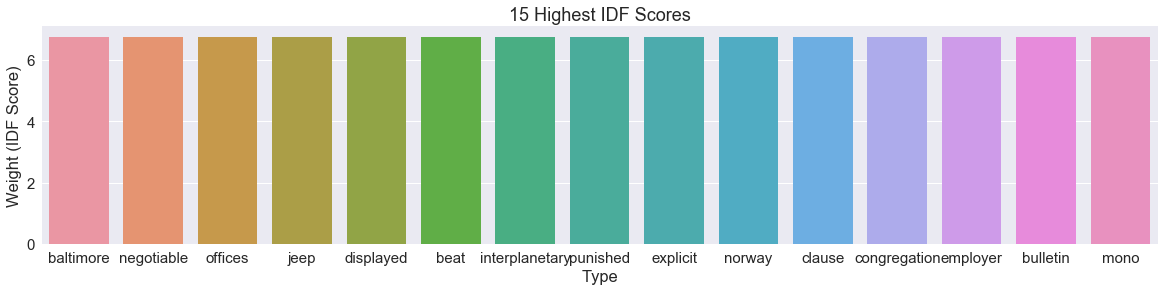

In [14]:
sns.set(font_scale=1.5)
sns.barplot(x='type', y='idf', data=idf_df.head(15))           
plt.title('15 Highest IDF Scores')
plt.xlabel('Type')
plt.ylabel('Weight (IDF Score)')
fig = plt.gcf()
fig.set_size_inches(20, 4)
plt.show()

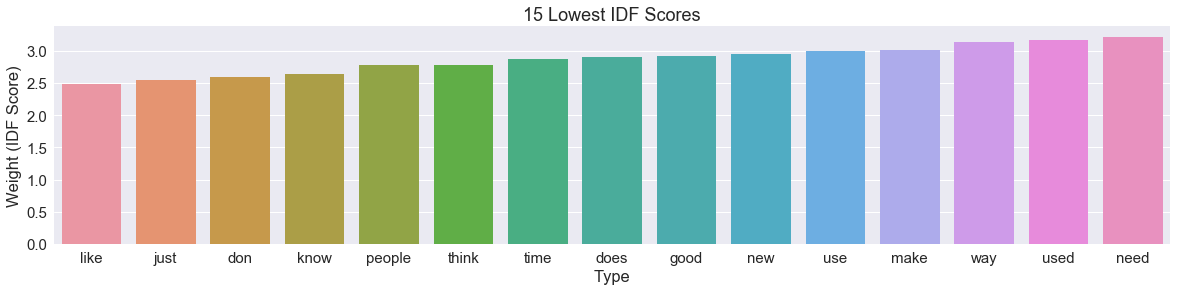

In [15]:
idf_df = idf_df.sort_values(by='idf', ascending=True)
sns.barplot(x='type', y='idf', data=idf_df.head(15))           
plt.title('15 Lowest IDF Scores')
plt.xlabel('Type')
plt.ylabel('Weight (IDF Score)')
fig = plt.gcf()
fig.set_size_inches(20, 4)
plt.show()

We can also transform the vocabulary (feature names) into a NumPy array and sort it by idf score to produce the same results as above.

In [16]:
feature_names = np.array(tfidf_vectorizer.get_feature_names()) 
sorted_by_idf = np.argsort(tfidf_vectorizer.idf_) 
print("Features with highest idf: {}".format(feature_names[sorted_by_idf[-10:]]))
print("Features with lowest idf: {}".format(feature_names[sorted_by_idf[:10]]))

Features with highest idf: ['beam' 'beat' 'bedroom' 'realistic' 'intention' 'belongs' 'desktop'
 'recording' 'compile' 'congregation']
Features with lowest idf: ['like' 'just' 'don' 'know' 'people' 'think' 'time' 'does' 'good' 'new']


In [17]:
max_scores = dtm_tfidf.max(axis=0).toarray().ravel() # Maximum tf-idf scores for tokens throughout the entire dataset.
sorted_by_tfidf = max_scores.argsort() 
print("Features with lowest tfidf: {}".format(feature_names[sorted_by_tfidf[:10]]))
print("Features with highest tfidf: {}".format(feature_names[sorted_by_tfidf[-10:]]))

Features with lowest tfidf: ['performing' 'initially' 'confusion' 'connected' 'pacific' 'aeronautics'
 'questioned' 'concluded' 'greeks' 'licenses']
Features with highest tfidf: ['hello' 'copy' 'thanks' 'wanted' 'contact' 'shipping' 'hell' 'times'
 'satan' 'says']


In [18]:
tfidf_dict = dict(zip(feature_names, max_scores))
tfidf_df = pd.DataFrame.from_dict(tfidf_dict, orient='index').reset_index()
tfidf_df.columns = ('type', 'tfidf')
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)
tfidf_df.head(15)

,type,tfidf
2521,says,1.0000
1016,thanks,1.0000
1096,course,1.0000
2414,wanted,1.0000
2966,hell,1.0000
327,copy,1.0000
3643,contact,1.0000
1789,agree,1.0000
3864,keywords,1.0000
731,shipping,1.0000


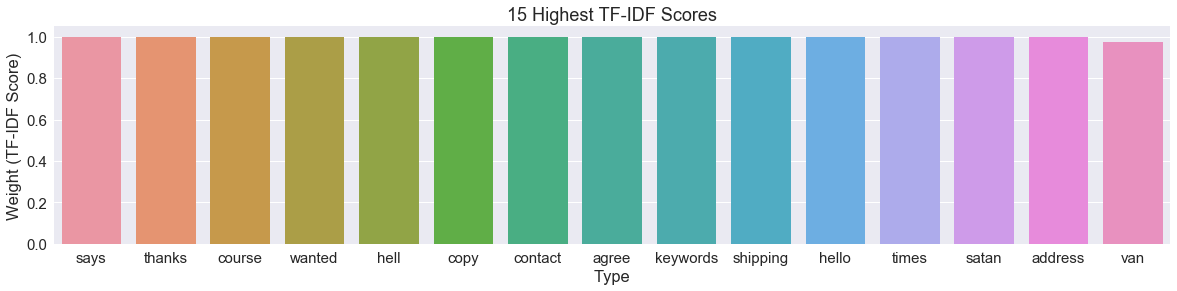

In [19]:
sns.barplot(x='type', y='tfidf', data=tfidf_df.head(15))           
plt.title('15 Highest TF-IDF Scores')
plt.xlabel('Type')
plt.ylabel('Weight (TF-IDF Score)')
fig = plt.gcf()
fig.set_size_inches(20, 4)
plt.show()

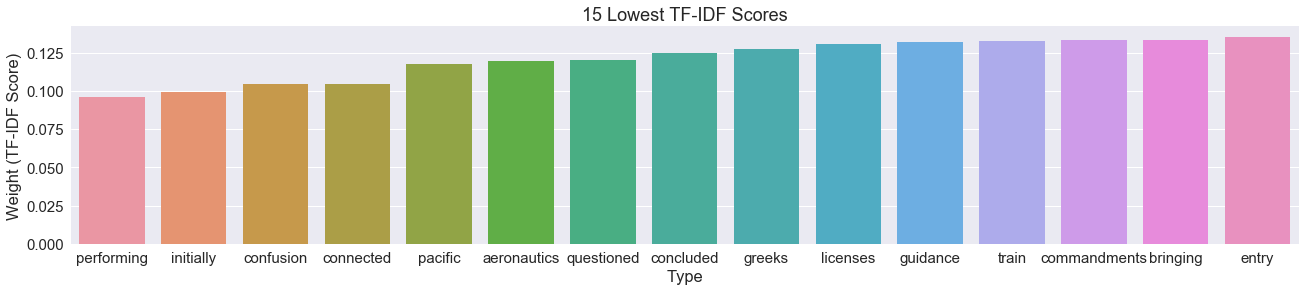

In [20]:
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=True)
sns.barplot(x='type', y='tfidf', data=tfidf_df.head(15))           
plt.title('15 Lowest TF-IDF Scores')
plt.xlabel('Type')
plt.ylabel('Weight (TF-IDF Score)')
fig = plt.gcf()
fig.set_size_inches(22, 4)
plt.show()

## Fit and assess LDA models

Now that we've created our document-term matrices using both tf and tf-idf scores, we can fit our topic model. We will be using the popular **Latent Dirichlet Allocation (LDA)** algorithm, which is probabilistic as opposed to deterministic. There are multiple high-quality LDA implementations in Python, of which Radim Řehůřek's [gensim](https://radimrehurek.com/gensim/) and Pedregosa et al.'s [version in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) are probably the most well-known. There is also Allen Riddell's excellent [lda](https://github.com/lda-project/lda) library, which implements the model using collapsed Gibbs sampling.

In this tutorial we will use the version in scikit-learn. Riddell's implementation is perhaps better quality but it is quite computationally intensive - because it implements collapsed Gibbs sampling, it requires hundreds (or even thousands) of iterations. We do not need the level of sophistication it represents for two reasons: 1) we are using a simple dataset with very distinctive categories, and 2) we don't have enough time to train the models!

Let's pretend we don't know how many topics there are in these six categories. We can start by looking at ten topics, and adjust the number based upon our interpretation of the results. Topic modelling is a highly iterative process - multiple models need to be fitted in order for the optimal parameters to be determined. It is also by definiton subjective: all the model presents us with are words that it thinks have a high probability of belonging to a topic. We have to interpret what these words mean and assign the topic a label; not all topics are meaningful and can be labelled. Moreover, determining the number of topics represented by a given corpus is both subjective and context-specific: the more granularity we desire, the greater the number of topics we need.

We will apply the LDA algorithm to the tf and tf-idf document-term matrices, to compare their results. Note that tf-idf might not necessarily produce better results, given the fact that our preprocessing is quite extensive. Model fitting and transformation will be performed in one step, because transformation is time-intensive.

In [21]:
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf_topics = lda_tf.fit_transform(dtm_tf)
print('Number of documents, number of topics:', lda_tf_topics.shape)
print('Number of topics, number of types:', lda_tf.components_.shape)

Number of documents, number of topics: (3501, 10)
Number of topics, number of types: (10, 3963)


Let's display the top ten word types that are associated with each of our topics. Each row in `components_` repesents a topic; we'll sort the types in descending order so that those that are most associated will come first. This is achieved through `[:, ::-1]`, which inverts the rows.

In [22]:
sorted_tf_types = np.argsort(lda_tf.components_, axis=1)[:, ::-1]

mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorted_tf_types, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
university    space         just          jpeg          new           
research      nasa          don           image         sale          
june          launch        like          dos           offer         
institute     earth         think         thanks        price         
fax           orbit         time          software      shipping      
conference    satellite     people        gif           condition     
education     shuttle       know          program       asking        
cview         lunar         good          use           sell          
reality       data          really        format        card          
virtual       mission       did           images        used          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
god 

Now let's pick a meaningful topic and display the five documents where the topic is most important.

In [23]:
cars = np.argsort(lda_tf_topics[:, 8])[::-1]
for i in cars[:5]:
    print(docs_raw[i])
    print('************')

Hi Folks,

I recently bought a 1981 Mercury Capri (my first car ever!).
I have noticed a few problems with the car :

	1. It gives very low gas mileage (something like
           11 miles / gallon ; I hear other car owners speak of
           gas-mileage figures like 25 miles/gallon (wow!) etc.).

	2. When I start the car, it goes into high idling (something
           like 1500 (or is it 15000 ?) rpm. After driving 4 or 5 miles, 
           it comes down to 300 (or 3000?) rpm. 

I would like to know if there is any way by which I can fix these
problems. Or is it natural for an old car like this ? (it has
done about 117,000 miles). Someone suggested that I change/rebuild/
recondition the carburettor. I am not prepared to do it
unless I am sure it will fix the problem. And yes, I got the
car tuned-up recently (within the last 200 miles or so).

Please let me know if you have any suggestions. Please respond
by email since I don't scan this newsgroup regularly.

Thanks.

Regards,

--Sudhi

In [24]:
lda_tfidf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tfidf_topics = lda_tfidf.fit_transform(dtm_tfidf)
print('Number of documents, number of topics:', lda_tfidf_topics.shape)
print('Number of topics, number of types:', lda_tfidf.components_.shape)

Number of documents, number of topics: (3501, 10)
Number of topics, number of types: (10, 3963)


In [25]:
sorted_tfidf_types = np.argsort(lda_tfidf.components_, axis=1)[:, ::-1]

mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorted_tfidf_types, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
keywords      shafer        larc          sale          god           
convertible   mary          nasa          thanks        jesus         
navy          dryden        gov           graphics      church        
steering      balls         reward        offer         christians    
seat          insisting     evening       shipping      bible         
wheel         tommy         freely        mail          christ        
imagine       ames          phil          email         christian     
visualization radius        space         card          faith         
presentations grows         just          files         christianity  
dan           increases     blessed       software      believe       


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
joe 

In [26]:
christianity = np.argsort(lda_tfidf_topics[:, 4])[::-1]
for i in christianity[:5]:
    print(docs_raw[i])
    print('************')




Sorry, but I think this interpretation of the Matthew 13 parables is
nonsense. I.e.,


Matthew 16:12 explains that by "leaven of the Pharisees" Jesus was simply
referring to their teaching; not sin/corruption/heresy.

Jesus gaves His apostles the keys of the kingdom and said that
the gates of hell would not prevail against His church.

************

I disagree with your claim that Jews were not evangelistic (except in
the narrow sense of the word).  Jewish proselytism was widespread.
There are numerous accounts of Jewish proselytism, both in the New
Testament and in Roman and Greek documents of the day.
************


Yep.  There's truth in all those religions, even in science.   
Christianity doesn't claim to know it all.  It does claim certain  
things are true though that contradict other religions' truth claims.   
So they can't all be true.

************


The reason for the existence of hell is justice.  Fear is only an effect
of the reality of hell.

-- 
boundary, the catechi

## Interactive visualisation with pyLDAvis

pyLDAvis is a very powerful library that facilitates the interpretation of topic model results via an interactive web-based visualisation. It is part of Carson Sievert and Kenny Shirley's R package.

pyLDAvis employs a dimension reduction technique (principal component analysis by default), through which the topics and their distances are plotted in a two-dimensional space. This is displayed on the left of the visualisation. Each circle represents a topic; the area of the circle represents the **topic prevalence** in the corpus. Topic indices (numbers) also indicate prevalence: the largest (most popular) topic is 1; the topic with the lowest number is the least popular. The percentage of tokens that constitute the topic is displayed in the title text on the right side of the visualisation.

The distance between two circles in the plot represents **topic similarity** (the extent to which their vocabularies overlap). This is only an approximation, as we're using a 2D plot to represent the spatial distribution of topics. When we have 10 topics, the similarity matrix has 45 pair-pair distances (`(10 x 9)/2`). This means that we need 45 dimensions to preserve all of the distances! Multidimensional scaling (dimension reduction) tries to preserve the original distances between all of the topics to the greatest possible extent.

On the right, the top 30 **most relevant terms for each topic** are displayed; this aligns with the terms we generated above (although the topic labels are not aligned). The red bar represents the estimated term frequency within the selected topic; the blue bar represents the overall term frequency in the corpus. A longer blue bar indicates that the word is not only relevant for the selected topic, but also for other topics.

To interpret the topics more effectively, we can play around with the value of **lambda (λ)** on the top right slider. When we change this value, the list of words changes. Lambda strikes a balance between choosing only jargon and choosing words that are more layman-oriented. If we want to see more jargon, we should move the slider to the 0 end of the spectrum. Notice that the blue bars disappear here, as we are seeing words that are exclusively relevant for the topic. If we increase the lambda value towards 1, we include terms that are also included in other topics (i.e., more readable words), and the blue bars get longer. 

Note that some 'topics' represent writing style as opposed to substance; they might consist of common words that express general sentiment. These are not meaningful themes.

Some topics could represent subcategories. If we are not interested in granularity, we should reduce the number of topics so that they can be merged.

Another nifty feature of pyLDAvis is that when we hover over a term in the bar chart, the plot shows its **conditional topic distribution**: how will other topics use it? By default, the marginal topic distribution is shown. 

pyLDAvis documentation: https://github.com/bmabey/pyLDAvis

In [27]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      20.144676        1       1  0.203165 -0.002101
2      19.219319        1       2  0.203883 -0.070433
1      11.441959        1       3 -0.085661  0.092103
3       9.063533        1       4 -0.117096 -0.144542
9       8.298980        1       5  0.109908  0.198465
6       8.227264        1       6 -0.253387 -0.115754
8       7.344788        1       7  0.189009 -0.090415
4       7.341271        1       8 -0.060245 -0.187886
7       7.148404        1       9 -0.037199  0.080086
0       1.769806        1      10 -0.152377  0.240476, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
3338  Default  1054.000000         space  1054.000000  30.0000  30.0000
1515  Default  1085.000000           god  1085.000000  29.0000  29.0000
1575  Default   633.000000           gun   633.000000  28.0000  28.0000
1349  Default   666.000000          file   666.000000  27.0000  27.0000
502   Default   599.000000           car   599.000000  26.0000  26.0000
1714  Default   550.000000         image   550.000000  25.0000  25.0000
1543  Default   441.000000      graphics   441.000000  24.0000  24.0000
1123  Default   662.000000           edu   662.000000  23.0000  23.0000
3735  Default   184.000000    university   184.000000  22.0000  22.0000
1860  Default   462.000000         jesus   462.000000  21.0000  21.0000
3091  Default   277.000000          sale   277.000000  20.0000  20.0000
1576  Default   284.000000          guns   284.000000  19.0000  19.0000
2316  Default   392.000000          nasa   392.000000  18.0000  18.0000
2981  Default   214.000000      research   214.000000  17.0000  17.0000
1449  Default   264.000000           ftp   264.000000  16.0000  16.0000
1894  Default  1011.000000          just  1011.000000  15.0000  15.0000
2013  Default  1144.000000          like  1144.000000  14.0000  14.0000
886   Default   455.000000          data   455.000000  13.0000  13.0000
1882  Default   299.000000          jpeg   299.000000  12.0000  12.0000
1952  Default   281.000000        launch   281.000000  11.0000  11.0000
2350  Default   839.000000           new   839.000000  10.0000  10.0000
589   Default   371.000000        church   371.000000   9.0000   9.0000
287   Default   420.000000     available   420.000000   8.0000   8.0000
1364  Default   230.000000      firearms   230.000000   7.0000   7.0000
2414  Default   252.000000         offer   252.000000   6.0000   6.0000
2551  Default  1125.000000        people  1125.000000   5.0000   5.0000
1773  Default   396.000000   information   396.000000   4.0000   4.0000
512   Default   214.000000          cars   214.000000   3.0000   3.0000
3308  Default   370.000000      software   370.000000   2.0000   2.0000
2705  Default   257.000000         price   257.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
3045  Topic10    37.468638        robert    44.042768   3.8726  -4.6326
1124  Topic10    40.880399     education    48.974785   3.8536  -4.5454
3133  Topic10    31.011056         scott    37.743298   3.8378  -4.8217
3824  Topic10    39.633144       virtual    48.699412   3.8283  -4.5764
2691  Topic10    20.003875  presentation    24.789437   3.8198  -5.2602
3178  Topic10     9.164412        senior    11.492219   3.8080  -6.0408
3448  Topic10    12.791592    structures    16.042002   3.8079  -5.7073
1890  Topic10    57.042139          june    71.687130   3.8058  -4.2123
3877  Topic10    13.025314     wednesday    16.646954   3.7890  -5.6892
1791  Topic10    54.151266     institute    74.844044   3.7107  -4.2643
726   Topic10    41.064118    conference    62.783617   3.6097  -4.5410
642   Topic10    29.871630       college    43.988737   3.6473  -4.8592
3485  Topic10    31.217235        summer    46.531470   3.6351  -4.81

In [28]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      64.858195        1       1  0.024896  0.113083
3      16.893134        1       2  0.228026 -0.120069
4       6.809647        1       3 -0.214049 -0.118048
1       1.749670        1       4 -0.006395  0.023340
5       1.647264        1       5 -0.006399  0.020804
9       1.615467        1       6 -0.005329  0.016819
2       1.611855        1       7 -0.005267  0.016437
0       1.606857        1       8 -0.005225  0.016202
8       1.603956        1       9 -0.005128  0.015714
6       1.603956        1      10 -0.005131  0.015717, topic_info=     Category       Freq          Term      Total  loglift  logprob
term                                                               
1515  Default  43.000000           god  43.000000  30.0000  30.0000
1860  Default  22.000000         jesus  22.000000  29.0000  29.0000
589   Default  18.000000        church  18.000000  28.0000  28.0000
587   Default  16.000000    christians  16.000000  27.0000  27.0000
350   Default  24.000000       believe  24.000000  26.0000  26.0000
3588  Default  37.000000        thanks  37.000000  25.0000  25.0000
585   Default  16.000000     christian  16.000000  24.0000  24.0000
365   Default  14.000000         bible  14.000000  23.0000  23.0000
3091  Default  27.000000          sale  27.000000  22.0000  22.0000
2551  Default  46.000000        people  46.000000  21.0000  21.0000
584   Default  13.000000        christ  13.000000  20.0000  20.0000
3112  Default  25.000000           say  25.000000  19.0000  19.0000
1291  Default  13.000000         faith  13.000000  18.0000  18.0000
1543  Default  23.000000      graphics  23.000000  17.0000  17.0000
2095  Default  27.000000          mail  27.000000  16.0000  16.0000
2007  Default  18.000000          life  18.000000  15.0000  15.0000
2414  Default  23.000000         offer  23.000000  14.0000  14.0000
3231  Default  18.000000      shipping  18.000000  13.0000  13.0000
1635  Default  13.000000          hell  13.000000  12.0000  12.0000
3693  Default  17.000000          true  17.000000  11.0000  11.0000
3697  Default  11.000000         truth  11.000000  10.0000  10.0000
1141  Default  24.000000         email  24.000000   9.0000   9.0000
1057  Default  39.000000          does  39.000000   8.0000   8.0000
503   Default  18.000000          card  18.000000   7.0000   7.0000
1123  Default  29.000000           edu  29.000000   6.0000   6.0000
586   Default   9.000000  christianity   9.000000   5.0000   5.0000
2057  Default  26.000000       looking  26.000000   4.0000   4.0000
1807  Default  23.000000    interested  23.000000   3.0000   3.0000
3308  Default  19.000000      software  19.000000   2.0000   2.0000
1350  Default  15.000000         files  15.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
2221  Topic10   0.070148        miller   3.236819   0.3010  -8.2797
659   Topic10   0.069995        comics   3.091553   0.3447  -8.2819
1515  Topic10   0.069848           god  43.054524  -2.2912  -8.2840
1123  Topic10   0.069843           edu  29.140529  -1.9009  -8.2841
1228  Topic10   0.069841     existence   5.601909  -0.2519  -8.2841
3734  Topic10   0.069837      universe   5.545915  -0.2420  -8.2842
3266  Topic10   0.069837        silver   2.342285   0.6200  -8.2842
1752  Topic10   0.069833    incredible   1.514026   1.0563  -8.2842
1520  Topic10   0.069831          gold   4.533983  -0.0406  -8.2842
2754  Topic10   0.069831      programs   8.464269  -0.6648  -8.2842
1849  Topic10   0.069826         james   7.387116  -0.5288  -8.2843
580   Topic10   0.069825        choose   4.506158  -0.0345  -8.2843
1883  Topic10   0.069823           jpl   3.515248   0.2138  -8.2844
150   Topic10   0.069822        annual   3.330740   0.2677  -8.2844
3127  Topic10   0.069822       science   8.986587  -0.7248  -8.2844
827   Topic10   0.069821         cover   8.50

### Multidimensional scaling

Scikit-learn's default multidimensional scaling function for the plotting of the intertopic distance map is **principle component analysis**. We can test other scaling functions to see if they improve the results. Several good options are MMDS and TSNE.

MMDS represents Jensen-Shannon Divergence & Metric Multidimensional Scaling; TSNE represents dimension reduction via Jensen-Shannon Divergence & t-distributed Stochastic Neighbor Embedding.

In [29]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      20.144676        1       1  0.214750  0.237297
2      19.219319        1       2  0.085217  0.157469
1      11.441959        1       3 -0.220488 -0.266341
3       9.063533        1       4 -0.101577  0.292468
9       8.298980        1       5  0.080915 -0.367679
6       8.227264        1       6 -0.287738  0.229424
8       7.344788        1       7 -0.040220 -0.069284
4       7.341271        1       8 -0.345275 -0.014441
7       7.148404        1       9  0.192231 -0.139273
0       1.769806        1      10  0.422185 -0.059640, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
3338  Default  1054.000000         space  1054.000000  30.0000  30.0000
1515  Default  1085.000000           god  1085.000000  29.0000  29.0000
1575  Default   633.000000           gun   633.000000  28.0000  28.0000
1349  Default   666.000000          file   666.000000  27.0000  27.0000
502   Default   599.000000           car   599.000000  26.0000  26.0000
1714  Default   550.000000         image   550.000000  25.0000  25.0000
1543  Default   441.000000      graphics   441.000000  24.0000  24.0000
1123  Default   662.000000           edu   662.000000  23.0000  23.0000
3735  Default   184.000000    university   184.000000  22.0000  22.0000
1860  Default   462.000000         jesus   462.000000  21.0000  21.0000
3091  Default   277.000000          sale   277.000000  20.0000  20.0000
1576  Default   284.000000          guns   284.000000  19.0000  19.0000
2316  Default   392.000000          nasa   392.000000  18.0000  18.0000
2981  Default   214.000000      research   214.000000  17.0000  17.0000
1449  Default   264.000000           ftp   264.000000  16.0000  16.0000
1894  Default  1011.000000          just  1011.000000  15.0000  15.0000
2013  Default  1144.000000          like  1144.000000  14.0000  14.0000
886   Default   455.000000          data   455.000000  13.0000  13.0000
1882  Default   299.000000          jpeg   299.000000  12.0000  12.0000
1952  Default   281.000000        launch   281.000000  11.0000  11.0000
2350  Default   839.000000           new   839.000000  10.0000  10.0000
589   Default   371.000000        church   371.000000   9.0000   9.0000
287   Default   420.000000     available   420.000000   8.0000   8.0000
1364  Default   230.000000      firearms   230.000000   7.0000   7.0000
2414  Default   252.000000         offer   252.000000   6.0000   6.0000
2551  Default  1125.000000        people  1125.000000   5.0000   5.0000
1773  Default   396.000000   information   396.000000   4.0000   4.0000
512   Default   214.000000          cars   214.000000   3.0000   3.0000
3308  Default   370.000000      software   370.000000   2.0000   2.0000
2705  Default   257.000000         price   257.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
3045  Topic10    37.468638        robert    44.042768   3.8726  -4.6326
1124  Topic10    40.880399     education    48.974785   3.8536  -4.5454
3133  Topic10    31.011056         scott    37.743298   3.8378  -4.8217
3824  Topic10    39.633144       virtual    48.699412   3.8283  -4.5764
2691  Topic10    20.003875  presentation    24.789437   3.8198  -5.2602
3178  Topic10     9.164412        senior    11.492219   3.8080  -6.0408
3448  Topic10    12.791592    structures    16.042002   3.8079  -5.7073
1890  Topic10    57.042139          june    71.687130   3.8058  -4.2123
3877  Topic10    13.025314     wednesday    16.646954   3.7890  -5.6892
1791  Topic10    54.151266     institute    74.844044   3.7107  -4.2643
726   Topic10    41.064118    conference    62.783617   3.6097  -4.5410
642   Topic10    29.871630       college    43.988737   3.6473  -4.8592
3485  Topic10    31.217235        summer    46.531470   3.6351  -4.81

In [30]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
5      20.144676        1       1   31.076223  396.468689
2      19.219319        1       2  372.068390  -78.326187
1      11.441959        1       3   55.030693 -128.849258
3       9.063533        1       4 -123.657661   74.866409
9       8.298980        1       5 -282.236847  305.000366
6       8.227264        1       6 -171.318100 -303.660034
8       7.344788        1       7  192.239914 -368.352966
4       7.341271        1       8  142.650757  127.890282
7       7.148404        1       9  376.725433  272.367432
0       1.769806        1      10 -373.735779  -53.713242, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
3338  Default  1054.000000         space  1054.000000  30.0000  30.0000
1515  Default  1085.000000           god  1085.000000  29.0000  29.0000
1575  Default   633.000000           gun   633.000000  28.0000  28.0000
1349  Default   666.000000          file   666.000000  27.0000  27.0000
502   Default   599.000000           car   599.000000  26.0000  26.0000
1714  Default   550.000000         image   550.000000  25.0000  25.0000
1543  Default   441.000000      graphics   441.000000  24.0000  24.0000
1123  Default   662.000000           edu   662.000000  23.0000  23.0000
3735  Default   184.000000    university   184.000000  22.0000  22.0000
1860  Default   462.000000         jesus   462.000000  21.0000  21.0000
3091  Default   277.000000          sale   277.000000  20.0000  20.0000
1576  Default   284.000000          guns   284.000000  19.0000  19.0000
2316  Default   392.000000          nasa   392.000000  18.0000  18.0000
2981  Default   214.000000      research   214.000000  17.0000  17.0000
1449  Default   264.000000           ftp   264.000000  16.0000  16.0000
1894  Default  1011.000000          just  1011.000000  15.0000  15.0000
2013  Default  1144.000000          like  1144.000000  14.0000  14.0000
886   Default   455.000000          data   455.000000  13.0000  13.0000
1882  Default   299.000000          jpeg   299.000000  12.0000  12.0000
1952  Default   281.000000        launch   281.000000  11.0000  11.0000
2350  Default   839.000000           new   839.000000  10.0000  10.0000
589   Default   371.000000        church   371.000000   9.0000   9.0000
287   Default   420.000000     available   420.000000   8.0000   8.0000
1364  Default   230.000000      firearms   230.000000   7.0000   7.0000
2414  Default   252.000000         offer   252.000000   6.0000   6.0000
2551  Default  1125.000000        people  1125.000000   5.0000   5.0000
1773  Default   396.000000   information   396.000000   4.0000   4.0000
512   Default   214.000000          cars   214.000000   3.0000   3.0000
3308  Default   370.000000      software   370.000000   2.0000   2.0000
2705  Default   257.000000         price   257.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
3045  Topic10    37.468638        robert    44.042768   3.8726  -4.6326
1124  Topic10    40.880399     education    48.974785   3.8536  -4.5454
3133  Topic10    31.011056         scott    37.743298   3.8378  -4.8217
3824  Topic10    39.633144       virtual    48.699412   3.8283  -4.5764
2691  Topic10    20.003875  presentation    24.789437   3.8198  -5.2602
3178  Topic10     9.164412        senior    11.492219   3.8080  -6.0408
3448  Topic10    12.791592    structures    16.042002   3.8079  -5.7073
1890  Topic10    57.042139          june    71.687130   3.8058  -4.2123
3877  Topic10    13.025314     wednesday    16.646954   3.7890  -5.6892
1791  Topic10    54.151266     institute    74.844044   3.7107  -4.2643
726   Topic10    41.064118    conference    62.783617   3.6097  -4.5410
642   Topic10    29.871630       college    43.988737   3.6473  -4.8592
3485  Topic10    31.2

## Exercises and Questions

1. Play around with the parameters - number of topics, MDS technique, tf vs. tf-idf. As an unsupervised technique, topic modelling requires a lot of work/interpretation. You have to experiment with multiple settings to determine the right number of topics. By doing this you'll also better understand how the settings work.

2. Which topics are most similar? Which are most distinctive? Can you come up with qualitative reasons for why?